# CEB 35300, Phylogenetic Comparative Methods 
## University of Chicago, 2018<br>Andrew Hipp, ahipp@mortonarb.org
### Session 9: Introduction to phylogenetic diversity

There is a whole suite of fun stuff we can do in phylogenetic ecology... more than you can shake a stick at. Here, we're just going to get a start with:
1. Phylogenetic diversity: diversity within communities
1. Phylogenetic $\beta$-diversity: diversity among communmities

First, let's get some data in here. We'll use data from an ecological experiment, which is sort of odd for these kinds of analyses: usually one uses data from real communities. However, this is a dataset I know well, and it allows us to do all the usual stuff (items 1-3 above) in addition to assess diversity effects (item 4 above), which you can only do directly in an experimental setting... but I get ahead of myself.

First a tree, because this _is_ a phylogenetic methods course:

Warning message:
"package 'ape' was built under R version 3.3.3"

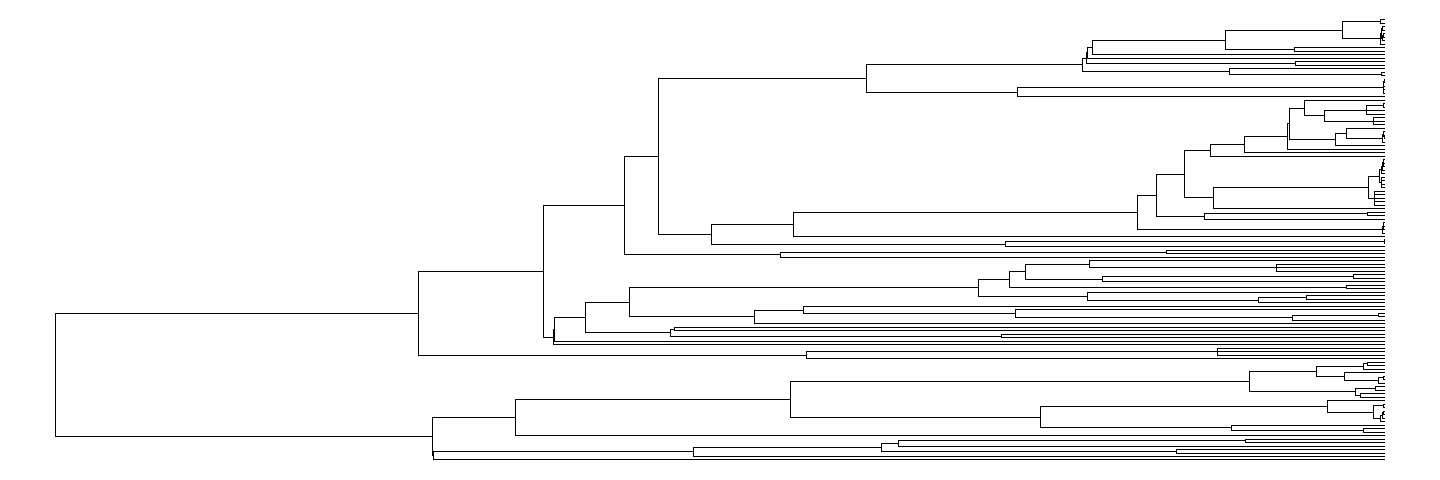

In [1]:
library(ape)

options(repr.plot.width=12, repr.plot.height=4) # this is just to make things plot nicely in Jupyter notebook
par(mar = rep(0.1, 4))
# let's make a little function to make it nicer-looking when we grab data off of Github
prairiePath = ('https://raw.githubusercontent.com/andrew-hipp/PCM-2018/master/R-tutorials/DATA/prairie/')
pr <- function(x, path = prairiePath) paste(path, x, sep = '')

# now let's read and plot our tree
tr.prairie <- read.tree(pr('tree.pruned.tre'))
plot(tr.prairie, show.tip.label = F)

Now let's read in data data on composition, soils, and a little metadata about the plots we are working with:

In [2]:
dat <- list(
    blocks = read.csv(pr('dat.blocksSoilCover.csv'), row.names = 1, as.is = T),
    composition = read.csv(pr('dat.composition.2017.csv'), row.names = 1, as.is = T),
    plotMeta = read.csv(pr('dat.cover.meta.2017.csv'), row.names = 1, as.is = T)
    )
## a little cleanup on two names
names(dat$composition) <- gsub('[.-]', '', names(dat$composition))
tr.prairie$tip.label <- gsub('[.-]', '', tr.prairie$tip.label)
dat$bin <- dat$composition
dat$bin[!is.na(dat$bin)] <- 1
dat$bin[is.na(dat$bin)] <- 0
tr.prairie <- drop.tip(tr.prairie, which(!tr.prairie$tip.label %in% names(dat$bin)))
t(sapply(dat, dim)) # shows number of rows and columns for each data.frame


blocks,437,14
composition,144,105
plotMeta,144,9
bin,144,105


## 1. Phylogenetic diversity
There are three most commonly used metrics of phylogenetic diverisity: PD, MPD, and MNTD

1. __PD__, phylogenetic diversity _sensu Faith_. The original formulation of phylogenetic diversity in Faith (1992, _Biological Conservation_ 61: 1-10) was very straightforward: it was the summed branch length in a tree pruned to just the taxa in a community. 
1. __MPD__, mean pairwise distance. The average pairwise distance between all taxa in a community.
1. __MNTD__, mean nearest taxon distance. The average distance from all taxa and their nearest relatives.

We can easily calculate each of these. Let's write a function that does all three:

In [3]:
phyD <- function(phy, roundDigits = 2) {
    out <- c(
        pd = sum(phy$edge.length),
        mpd = mean(as.dist(cophenetic(phy))),
        mntd = mean(apply(cophenetic(phy), 1, function(x) min(x[x > 0])))
        )
    out <- round(out, roundDigits)
    out
}
phyD(tr.prairie)

pd     mpd    mntd 
3372.40  245.12   37.88

### Challenge Question 1a
With your partner, write a function that calculates pd, mpd, or mntd for all communities in the `dat$bin` object above, and compare with the function of the same name (`pd`, `mpd`, or `mntd`) in the `picante` package. Hint: use `drop.tip` to prune your tree.

### Challenge Question 1b
The phylogenetic level of the plots as designed is lurking in `dat$plotMeta$phyD` (H = high, M = medium, L = low). How well do these levels match the observed phylogenetic diversity? 

### Challenge Question 2
Are mpd, mntd, and pd sample-size sensitive? What about the standardized effect size of each statistic, calculated as the number of standard deviations above (if positive) or below (if negative) the mean statistic, where the mean and $\sigma$ are estimated by permutation (see `?ses.pd` for more information). Simulate a tree of 1000 taxa, then simulate 200 communities that randomly sample from anywhere from 10 to 1000 taxa. Plot the three statistics against sample size and their three standardized effect sizes against sample size to see how they vary with sample size.
* __Hint 1:__ use `sim.bdtree` from `geiger`
* __Hint 2:__ the community matrix will be a 1/0 matrix 200 rows $\times$ 1000 columns
* __Hint 3:__ to randomly fill the community matrix, create it full of 0s (read documentation for `matrix`), then index the elements of each row using `sample(1:1000, sample(10:1000, 1))` and fill those elements with 1's
* __Hint 4:__ all the documentation you need for pd, ses.pd, and the other functions is in the `caper` package


## 2. Phylogenetic $\beta$-diversity

Phylogenetic $\beta$-diversity is the diversity _among_ communities rather than within communities. Graham and Fine 2008 suggest mpd and mntd analogs, where the branch-length distances are between rather than within communities. To calculate these, one would have to create a rectangular matrix with all taxa in one community as rows, and all taxa in the other community as columns. Let's try this together for just two communities:

In [4]:
tr.prairie.dist <- cophenetic(tr.prairie)
comm.1_2 <- tr.prairie.dist[names(dat$bin)[dat$bin[1, ] == 1],
                            names(dat$bin)[dat$bin[2, ] == 1]
                            ]

The array we have just created has the pairwise distances between all taxa in it. Thus $\beta$-mpd would just be calculated as `mean(comm.1_2)`, while $\beta$-mntd would be calculated as `mean(apply(comm.1_2, 1, min) + apply(comm.1_2, 2, min))`.

### Challenge Question 3
Create a function that returns $\beta$-mpd or $\beta$-mntd for a matrix of communities: the output should be a pairwise distance matrix of dimensions equal in rows and columns to the number of communities in your input matrix.

### Challenge Question 4
Use the function you created above to test whether differences in soil A-horizon depth or any other soil parameter predicts phylogenetic $\beta$-diversity. Soil data are in `dat$blocks`. You may want to use a Mantel test to test significance of this correlation; see the `vegan` package for this.

### Challenge Question 5
Create a function to calculate the standardized effect size for $\beta$-mpd or $\beta$-mntd. Standardized effect sizes are calculated as:

$$z = {x-\mu \over \sigma}$$
$x$ = observed statistic<br>
$\mu$ = statistic averaged over permutations<br>
$\sigma$ = standard deviation of statistic over permuations